# Combating Anti-Asian Sentiment, Path to Recovery


## Import Packages 

In [ ]:
## To run the code in Google Colab, please enable local run time
## Connect for the first time:
 # pip install jupyter_http_over_ws
 # jupyter serverextension enable --py jupyter_http_over_ws

## For subsequent local runtime connection just type this command in conda terminal:
 # jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
## On colab, click connect -> connect to local runtime -> copy and paste notebook url to the popped window 

In [ ]:
# Run the pip install command below if you don't already have the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git
# Run the below command if you don't already have Pandas
# !pip install pandas
# !pip install re

# Imports
import snscrape.modules.twitter as sntwitter
import pandas as pd
import re
from datetime import date
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# NLP Imports
# Download these if you haven't installed them
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
# nltk.download('punkt')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Topic Modeling Imports
# Install packages for LDA model and visualization
# pip install gensim
# Conda terminal：$conda install -c conda-forge spacy \ python -m spacy download en_core_web_sm \ conda install -c conda-forge pyldavis
import gensim, spacy
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

## Define Tweets Scraping Function Design
Reference: https://github.com/igorbrigadir/twitter-advanced-search  


In [ ]:
# Setting the start and end dates from scraping

def twitter_scraper (startdate, enddate, min_faves):
    tweets_list = []
    query = '(china OR chinese OR asian) (covid OR virus OR corona OR pandemic) since:{} until:{} lang:en min_faves:{}'.format(startdate, enddate, min_faves)
    
    # Using TwitterSearchScraper to scrape data and append tweets to list
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        tweets_list.append([tweet.place, tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.replyCount, tweet.retweetCount, tweet.likeCount])
        
    # Creating a dataframe with the tweets
    tweets_df = pd.DataFrame(tweets_list, columns=['Place', 'Datetime', 'Tweet Id', 'Text', 'Username','replyCount', 'retweetCount', 'likeCount'])

    #Sort the tweets to show the most popular ones on top
    tweets_df['reactionSum'] = tweets_df['replyCount'] + tweets_df['retweetCount'] + tweets_df['likeCount']
    tweets_df = tweets_df.sort_values(by='reactionSum',ascending=False,ignore_index=True)
    
    #Show the first 10 tweets
    tweets_df.head(10)
    return tweets_df

In [ ]:
# Text cleaning
#pip install tweet-preprocessor
import preprocessor as p
stop_words = set(stopwords.words("english"))
more_stopwords = {'&amp', 'amp'}
stop_words = stop_words.union(more_stopwords)

def preprocessor(text):
    #preprocessor package for tweets cleaning
    text = p.clean(text)        
    #remove stopwords
    tokenized = word_tokenize(text)
    text = [w for w in tokenized if not w in stop_words]
    text = " ".join(text)
    
    return text   

In [ ]:
# Sentiment analysis

# 1. Prep the words
sia = SentimentIntensityAnalyzer()

# Add some common racial slurs/hashtags towards the Asian community to help label racist negative tweets
# Also add postive anti-racist words and hashtags to mitigate bias and mislabeling
new_words = {
    #Negative new words
    '#chinesevirus': -10.0,
    'chink': -20.0,
    'chinaman': -20.0,
    'ching chong': -20.0,
    'ling long': -20.0,
    'walla': -20.0,
    '#kungflu': -20.0,
    '#wuhanvirus': -10.0,
    '#wuflu': -20.0,
    'chinesecorona': -10.0,
    
    #Positive new words
    '#racismisavirus': 30.0,
    '#stopasianhate': 30.0,
    'stop racism': 30.0,
    '#antiracism': 30.0,
    'dont be racist': 30.0,
    'not chinesevirus': 30.0,
    'not wuflu': 30.0,
    'not wuhanvirus': 30.0,
    'not kungflu': 30.0
}

sia.lexicon.update(new_words)

In [ ]:
def tweets_analysis (startdate, enddate, min_faves):
    
    #1. Scrape the tweets
    tweets_df = twitter_scraper(startdate, enddate, min_faves)
    
    #2. Clean the tweets
    tweets_df['processedText'] = tweets_df['Text'].apply(preprocessor)
    
    #3. Sentiment analysis 
    tweets_df['polarity_scores'] = tweets_df['processedText'].map(lambda text: sia.polarity_scores(text)['compound'])
    tweets_df.loc[tweets_df['polarity_scores'] > 0.2, 'sentiment'] = 'positive' 
    tweets_df[(tweets_df['polarity_scores'] >= -0.2) & (tweets_df['polarity_scores'] <= 0.2)]['sentiment'] = 'neutral'  
    tweets_df.loc[tweets_df['polarity_scores'] < -0.2, 'sentiment'] = 'negative' 
    
    return tweets_df

## Topic Modeling Function Design -- A Latent Dirichlet Allocation (LDA) Model

In [ ]:
## Latent Dirichlet Allocation (LDA)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(text):
    return [[w for w in i if w not in stop_words] for i in text]
    

def topic_modeling(data,num_topics):
    # Convert sentences to words
    data_words = list(sent_to_words(data))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    #Remove stopwords
    data_words = remove_stopwords(data_words)

    #Create bigrams and trigrams
    data_words = [bigram_mod[text] for text in data_words]
    data_words =  [trigram_mod[bigram_mod[text]] for text in data_words]

    #Lemmatization
    #Initialize spacy 'en' model
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    processed_text = []
    postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    for text in data_words:
        doc = nlp(" ".join(text)) 
        processed_text.append([token.lemma_ for token in doc if token.pos_ in postags])
    
    #Remove stopwords again after lemmatization
    data_words = remove_stopwords(processed_text)
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

    # Model Perplexity (lower the better)
    print('\n\nModel Perplexity: ', lda_model.log_perplexity(corpus)) 

    # Topic Visualization
    pyLDAvis.enable_notebook()
    visualization = gensimvis.prepare(lda_model, corpus, id2word)
    return visualization

## Time period 1: Focus on the time period near Trump's first tweet(03-17-2020) on 'Chinese Virus' 2020-03-02 ~ 2020-04-01

In [ ]:
tweets_df1=[]
tweets_df1 = tweets_analysis(startdate = "2020-03-02", enddate = "2020-04-01", min_faves = 100)

In [ ]:
# Save negative tweets
negative_df1 = tweets_df1[tweets_df1['sentiment'] == 'negative'].sort_values(by = 'polarity_scores')
negative_df1 = negative_df1.reset_index(drop=True)

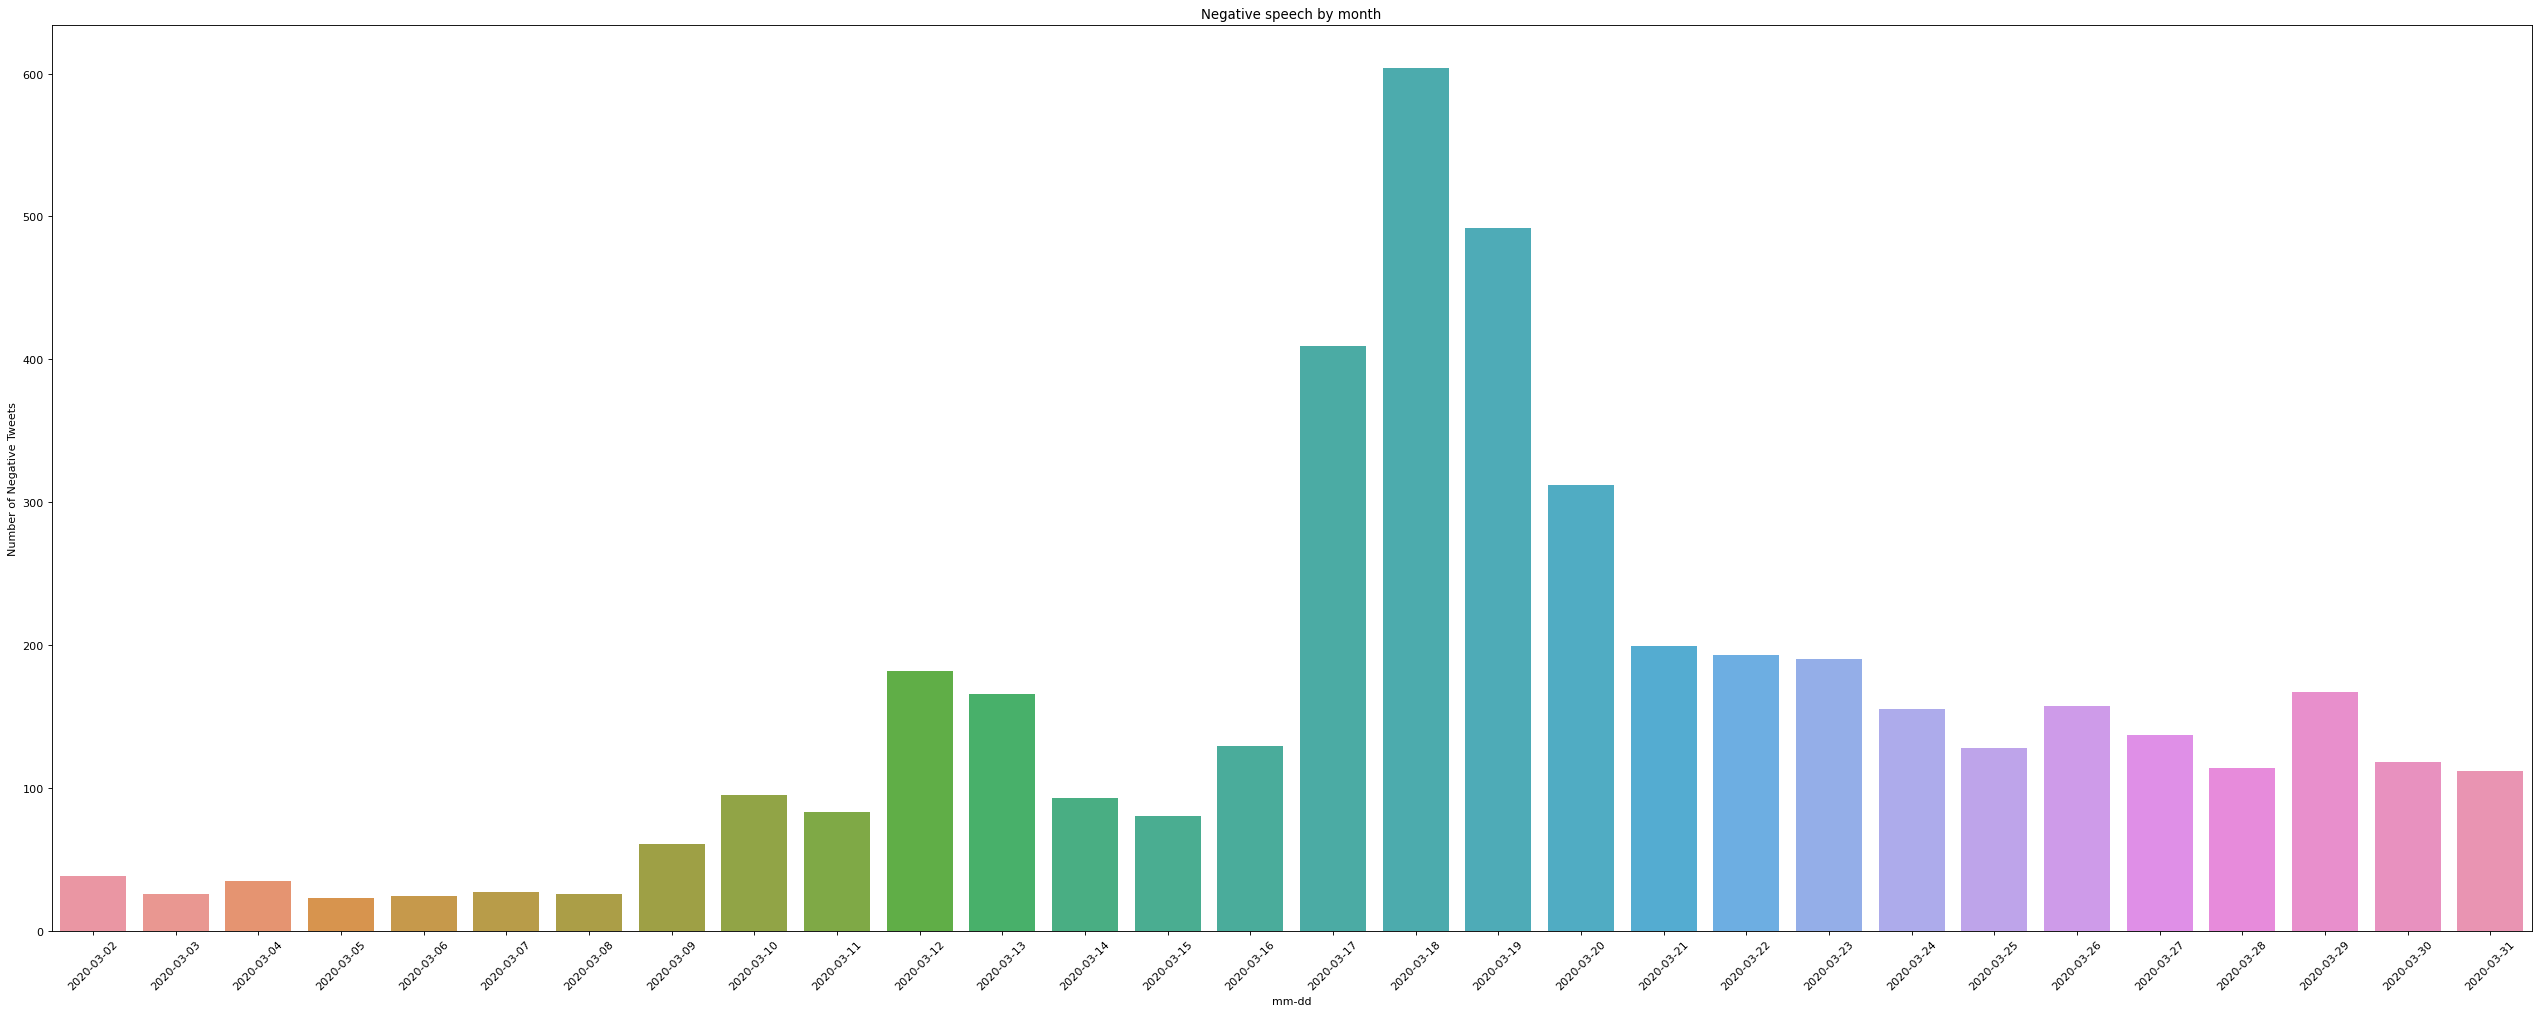

In [ ]:
# Plot the count of nagetive-sentiment speech by date
negative_df1['Date'] = negative_df1['Datetime'].map(lambda datetime: datetime.date())
negative_df1 = negative_df1.sort_values(by='Date')

## Plot
figure(figsize=(40, 15), dpi=80)

ax = sns.countplot(x = 'Date', data = negative_df1)
ax.set(xlabel = 'mm-dd', ylabel = 'Number of Negative Tweets')
plt.xticks(rotation=45)
plt.title('Negative speech by month')
plt.show()

### WordCloud 03/02/2020 - 04/01/2020 Entire time period

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


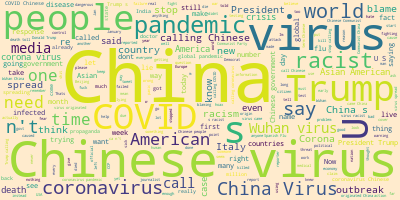

In [ ]:
#pip install wordcloud
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_text = ','.join(list(negative_df1['processedText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="blanchedalmond", max_words=5000, contour_width=3, contour_color='firebrick')
# Generate a word cloud
wordcloud.generate(long_text)
# Visualize the word cloud
wordcloud.to_image()

### WordCloud 03/02/2020 - 03/16/2020 Before Trump called out Chinese virus

In [ ]:
negative_df1_1 = negative_df1[(negative_df1['Datetime'] >= pd.Timestamp(2020,3,2).tz_localize('US/Eastern')) & (negative_df1['Datetime'] <= pd.Timestamp(2020,3,16).tz_localize('US/Eastern'))]

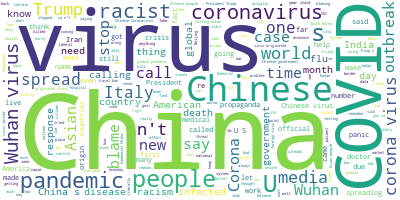

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_text = ','.join(list(negative_df1_1['processedText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='firebrick')
# Generate a word cloud
wordcloud.generate(long_text)
# Visualize the word cloud
wordcloud.to_image()

### Wordcloud 03/17/2020 - 03/21/2020 (Peak of Event)

In [ ]:
negative_df1_2 = negative_df1[(negative_df1['Datetime'] >= pd.Timestamp(2020,3,17).tz_localize('US/Eastern')) & (negative_df1['Datetime'] <= pd.Timestamp(2020,3,21).tz_localize('US/Eastern'))]

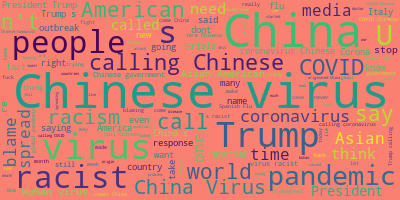

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_text = ','.join(list(negative_df1_2['processedText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="salmon", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_text)
# Visualize the word cloud
wordcloud.to_image()

### Wordcloud 03/22/2020 - 04/1/2020 (After Event)

In [ ]:
negative_df1_3 = negative_df1[(negative_df1['Datetime'] >= pd.Timestamp(2020,3,22).tz_localize('US/Eastern')) & (negative_df1['Datetime'] <= pd.Timestamp(2020,4,1).tz_localize('US/Eastern'))]

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


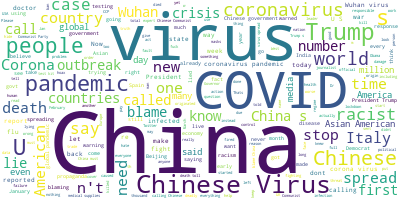

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_text = ','.join(list(negative_df1_3['processedText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_text)
# Visualize the word cloud
wordcloud.to_image()

### Topic Model 03/02/2020 - 03/16/2020 Before Trump called out Chinese virus

Negative tweets

In [ ]:
data = negative_df1_1['processedText'].values.tolist()
viz1 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.014*"india" + 0.014*"corona" + 0.010*"flu" + 0.009*"asian" + '
  '0.007*"europe" + 0.007*"fail" + 0.006*"avoid" + 0.006*"way" + '
  '0.005*"school" + 0.005*"travel"'),
 (1,
  '0.056*"china" + 0.052*"virus" + 0.023*"chinese" + 0.014*"people" + '
  '0.014*"wuhan" + 0.012*"pandemic" + 0.011*"trump" + 0.011*"call" + '
  '0.010*"coronavirus" + 0.009*"spread"'),
 (2,
  '0.026*"china" + 0.015*"italy" + 0.014*"covid" + 0.013*"case" + '
  '0.011*"country" + 0.008*"death" + 0.008*"bad" + 0.008*"corona" + '
  '0.008*"outbreak" + 0.007*"day"')]


Model Perplexity:  -7.381593291779077


In [ ]:
%matplotlib auto
pyLDAvis.display(viz1)

All tweets

In [ ]:
tweets_df1_1 = tweets_df1[(tweets_df1['Datetime'] >= pd.Timestamp(2020,3,2).tz_localize('US/Eastern')) & (tweets_df1['Datetime'] <= pd.Timestamp(2020,3,16).tz_localize('US/Eastern'))]
data = tweets_df1_1['processedText'].values.tolist()
viz2 = topic_modeling(data, 4)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.047*"china" + 0.035*"virus" + 0.031*"covid" + 0.018*"corona" + '
  '0.017*"people" + 0.015*"asian" + 0.013*"say" + 0.013*"chinese" + '
  '0.013*"case" + 0.012*"coronavirus"'),
 (1,
  '0.047*"call" + 0.035*"racist" + 0.018*"name" + 0.012*"way" + 0.009*"racism" '
  '+ 0.008*"maybe" + 0.007*"medicine" + 0.007*"least" + 0.007*"business" + '
  '0.007*"dem"'),
 (2,
  '0.055*"china" + 0.052*"virus" + 0.026*"chinese" + 0.019*"wuhan" + '
  '0.014*"get" + 0.014*"world" + 0.012*"trump" + 0.011*"spread" + '
  '0.011*"pandemic" + 0.010*"medium"'),
 (3,
  '0.015*"try" + 0.012*"right" + 0.011*"measure" + 0.010*"response" + '
  '0.009*"italy" + 0.008*"ban" + 0.008*"change" + 0.007*"usa" + 0.007*"hear" + '
  '0.007*"lockdown"')]


Model Perplexity:  -7.691255810229528


In [ ]:
pyLDAvis.display(viz2)

### Topic Model 03/17/2020 - 03/21/2020 (Peak of Event)

Negative tweets

In [ ]:
data = negative_df1_2['processedText'].values.tolist()
viz3 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.013*"italy" + 0.012*"new" + 0.011*"flu" + 0.010*"case" + 0.010*"covid" + '
  '0.008*"death" + 0.008*"first" + 0.007*"infect" + 0.006*"back" + '
  '0.006*"pompeo"'),
 (1,
  '0.012*"outbreak" + 0.011*"spread" + 0.011*"corona" + 0.008*"hide" + '
  '0.008*"fuck" + 0.007*"doctor" + 0.007*"news" + 0.006*"control" + '
  '0.006*"fucking" + 0.006*"take"'),
 (2,
  '0.063*"virus" + 0.050*"chinese" + 0.046*"china" + 0.025*"trump" + '
  '0.024*"call" + 0.018*"racist" + 0.014*"coronavirus" + 0.014*"people" + '
  '0.013*"pandemic" + 0.012*"say"')]


Model Perplexity:  -7.143048509470066


In [ ]:
pyLDAvis.display(viz3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


All tweets

In [ ]:
tweets_df1_2 = tweets_df1[(tweets_df1['Datetime'] >= pd.Timestamp(2020,3,17).tz_localize('US/Eastern')) & (tweets_df1['Datetime'] <= pd.Timestamp(2020,3,21).tz_localize('US/Eastern'))]
data = tweets_df1_2['processedText'].values.tolist()
viz4 = topic_modeling(data, 4)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.017*"food" + 0.012*"twitter" + 0.012*"maybe" + 0.011*"business" + '
  '0.011*"feel" + 0.010*"man" + 0.010*"word" + 0.010*"stupid" + '
  '0.009*"seriously" + 0.009*"white"'),
 (1,
  '0.113*"virus" + 0.084*"chinese" + 0.042*"call" + 0.033*"trump" + '
  '0.026*"china" + 0.019*"racist" + 0.018*"people" + 0.018*"say" + '
  '0.014*"coronavirus" + 0.013*"come"'),
 (2,
  '0.088*"china" + 0.029*"pandemic" + 0.021*"world" + 0.019*"covid" + '
  '0.016*"spread" + 0.010*"global" + 0.009*"country" + 0.009*"lie" + '
  '0.009*"wuhan" + 0.008*"new"'),
 (3,
  '0.016*"get" + 0.013*"government" + 0.013*"well" + 0.010*"people" + '
  '0.010*"thing" + 0.010*"corona" + 0.010*"good" + 0.009*"today" + '
  '0.009*"propaganda" + 0.008*"give"')]


Model Perplexity:  -7.344074062070266


In [ ]:
pyLDAvis.display(viz4)

### Topic Model 03/18/2020 - 04/01/2020 (After Event)

Negative tweets

In [ ]:
data = negative_df1_3['processedText'].values.tolist()
viz5 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.031*"case" + 0.025*"report" + 0.016*"new" + 0.007*"high" + 0.006*"find" + '
  '0.006*"covid" + 0.006*"ask" + 0.006*"give" + 0.006*"already" + '
  '0.005*"measure"'),
 (1,
  '0.060*"china" + 0.043*"virus" + 0.025*"chinese" + 0.017*"pandemic" + '
  '0.016*"covid" + 0.013*"trump" + 0.009*"world" + 0.009*"people" + '
  '0.009*"call" + 0.009*"coronavirus"'),
 (2,
  '0.008*"testing" + 0.008*"send" + 0.007*"block" + 0.006*"hate" + '
  '0.006*"group" + 0.005*"faulty" + 0.005*"bill" + 0.005*"donate" + '
  '0.005*"twitter" + 0.005*"bring"')]


Model Perplexity:  -7.454049367247519


In [ ]:
pyLDAvis.display(viz5)

All tweets

In [ ]:
tweets_df1_3 = tweets_df1[(tweets_df1['Datetime'] >= pd.Timestamp(2020,3,18).tz_localize('US/Eastern')) & (tweets_df1['Datetime'] <= pd.Timestamp(2020,4,1).tz_localize('US/Eastern'))]
data = tweets_df1_3['processedText'].values.tolist()
viz6 = topic_modeling(data, 4)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.020*"need" + 0.010*"believe" + 0.009*"cause" + 0.008*"test" + '
  '0.008*"state" + 0.008*"food" + 0.008*"ccp" + 0.007*"bring" + 0.007*"infect" '
  '+ 0.006*"origin"'),
 (1,
  '0.022*"take" + 0.013*"name" + 0.012*"response" + 0.009*"disease" + '
  '0.008*"life" + 0.008*"control" + 0.008*"word" + 0.008*"find" + 0.008*"job" '
  '+ 0.008*"seem"'),
 (2,
  '0.110*"china" + 0.043*"covid" + 0.030*"pandemic" + 0.022*"world" + '
  '0.014*"country" + 0.014*"case" + 0.009*"italy" + 0.009*"day" + 0.009*"help" '
  '+ 0.009*"new"'),
 (3,
  '0.101*"virus" + 0.069*"chinese" + 0.029*"call" + 0.029*"trump" + '
  '0.022*"china" + 0.018*"people" + 0.016*"say" + 0.013*"racist" + '
  '0.012*"come" + 0.011*"american"')]


Model Perplexity:  -7.5570168330705


In [ ]:
pyLDAvis.display(viz6)

### Topic Model 03/02/2020 - 04/01/2020 Entire time period

Negative Tweets

In [ ]:
data = negative_df1['processedText'].values.tolist()
viz7 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.016*"send" + 0.013*"mask" + 0.012*"war" + 0.010*"fire" + 0.009*"believe" '
  '+ 0.008*"testing" + 0.008*"india" + 0.008*"supply" + 0.008*"jan" + '
  '0.007*"human"'),
 (1,
  '0.073*"chinese" + 0.056*"virus" + 0.041*"trump" + 0.028*"call" + '
  '0.017*"say" + 0.016*"blame" + 0.016*"racist" + 0.016*"american" + '
  '0.014*"coronavirus" + 0.013*"asian"'),
 (2,
  '0.073*"china" + 0.029*"virus" + 0.020*"pandemic" + 0.020*"covid" + '
  '0.011*"world" + 0.010*"lie" + 0.009*"country" + 0.009*"people" + '
  '0.008*"case" + 0.007*"spread"')]


Model Perplexity:  -7.438585133468696


In [ ]:
pyLDAvis.display(viz7)

All tweets

In [ ]:
data = tweets_df1['processedText'].values.tolist()
viz8 = topic_modeling(data, 4)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.083*"virus" + 0.073*"china" + 0.053*"chinese" + 0.023*"call" + '
  '0.022*"covid" + 0.020*"trump" + 0.017*"people" + 0.013*"say" + '
  '0.013*"pandemic" + 0.011*"racist"'),
 (1,
  '0.014*"help" + 0.014*"global" + 0.013*"bad" + 0.013*"work" + 0.012*"also" + '
  '0.010*"response" + 0.009*"fight" + 0.009*"today" + 0.008*"pandemic" + '
  '0.007*"show"'),
 (2,
  '0.026*"government" + 0.023*"italy" + 0.010*"back" + 0.009*"place" + '
  '0.009*"propaganda" + 0.009*"disease" + 0.008*"allow" + 0.008*"bring" + '
  '0.008*"iran" + 0.007*"seem"'),
 (3,
  '0.021*"take" + 0.014*"country" + 0.011*"really" + 0.011*"keep" + '
  '0.010*"leave" + 0.008*"day" + 0.008*"food" + 0.007*"actually" + '
  '0.006*"hear" + 0.006*"close"')]


Model Perplexity:  -7.617637488561595


In [ ]:
pyLDAvis.display(viz8)

## Time Period 2: Atlanta Mass Shooting & Stop Asian Hate Movement 2021-03-01 ~ 2021-03-31

In [ ]:
# Scrape the tweets within the time period 2 time frame
tweets_df2 = tweets_analysis(startdate = "2021-03-01", enddate = "2021-03-31", min_faves = 100)

In [ ]:
# Save negative tweets
negative_df2 = tweets_df2[tweets_df2['sentiment'] == 'negative'].sort_values(by = 'polarity_scores')
negative_df2 = negative_df2.reset_index(drop=True)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


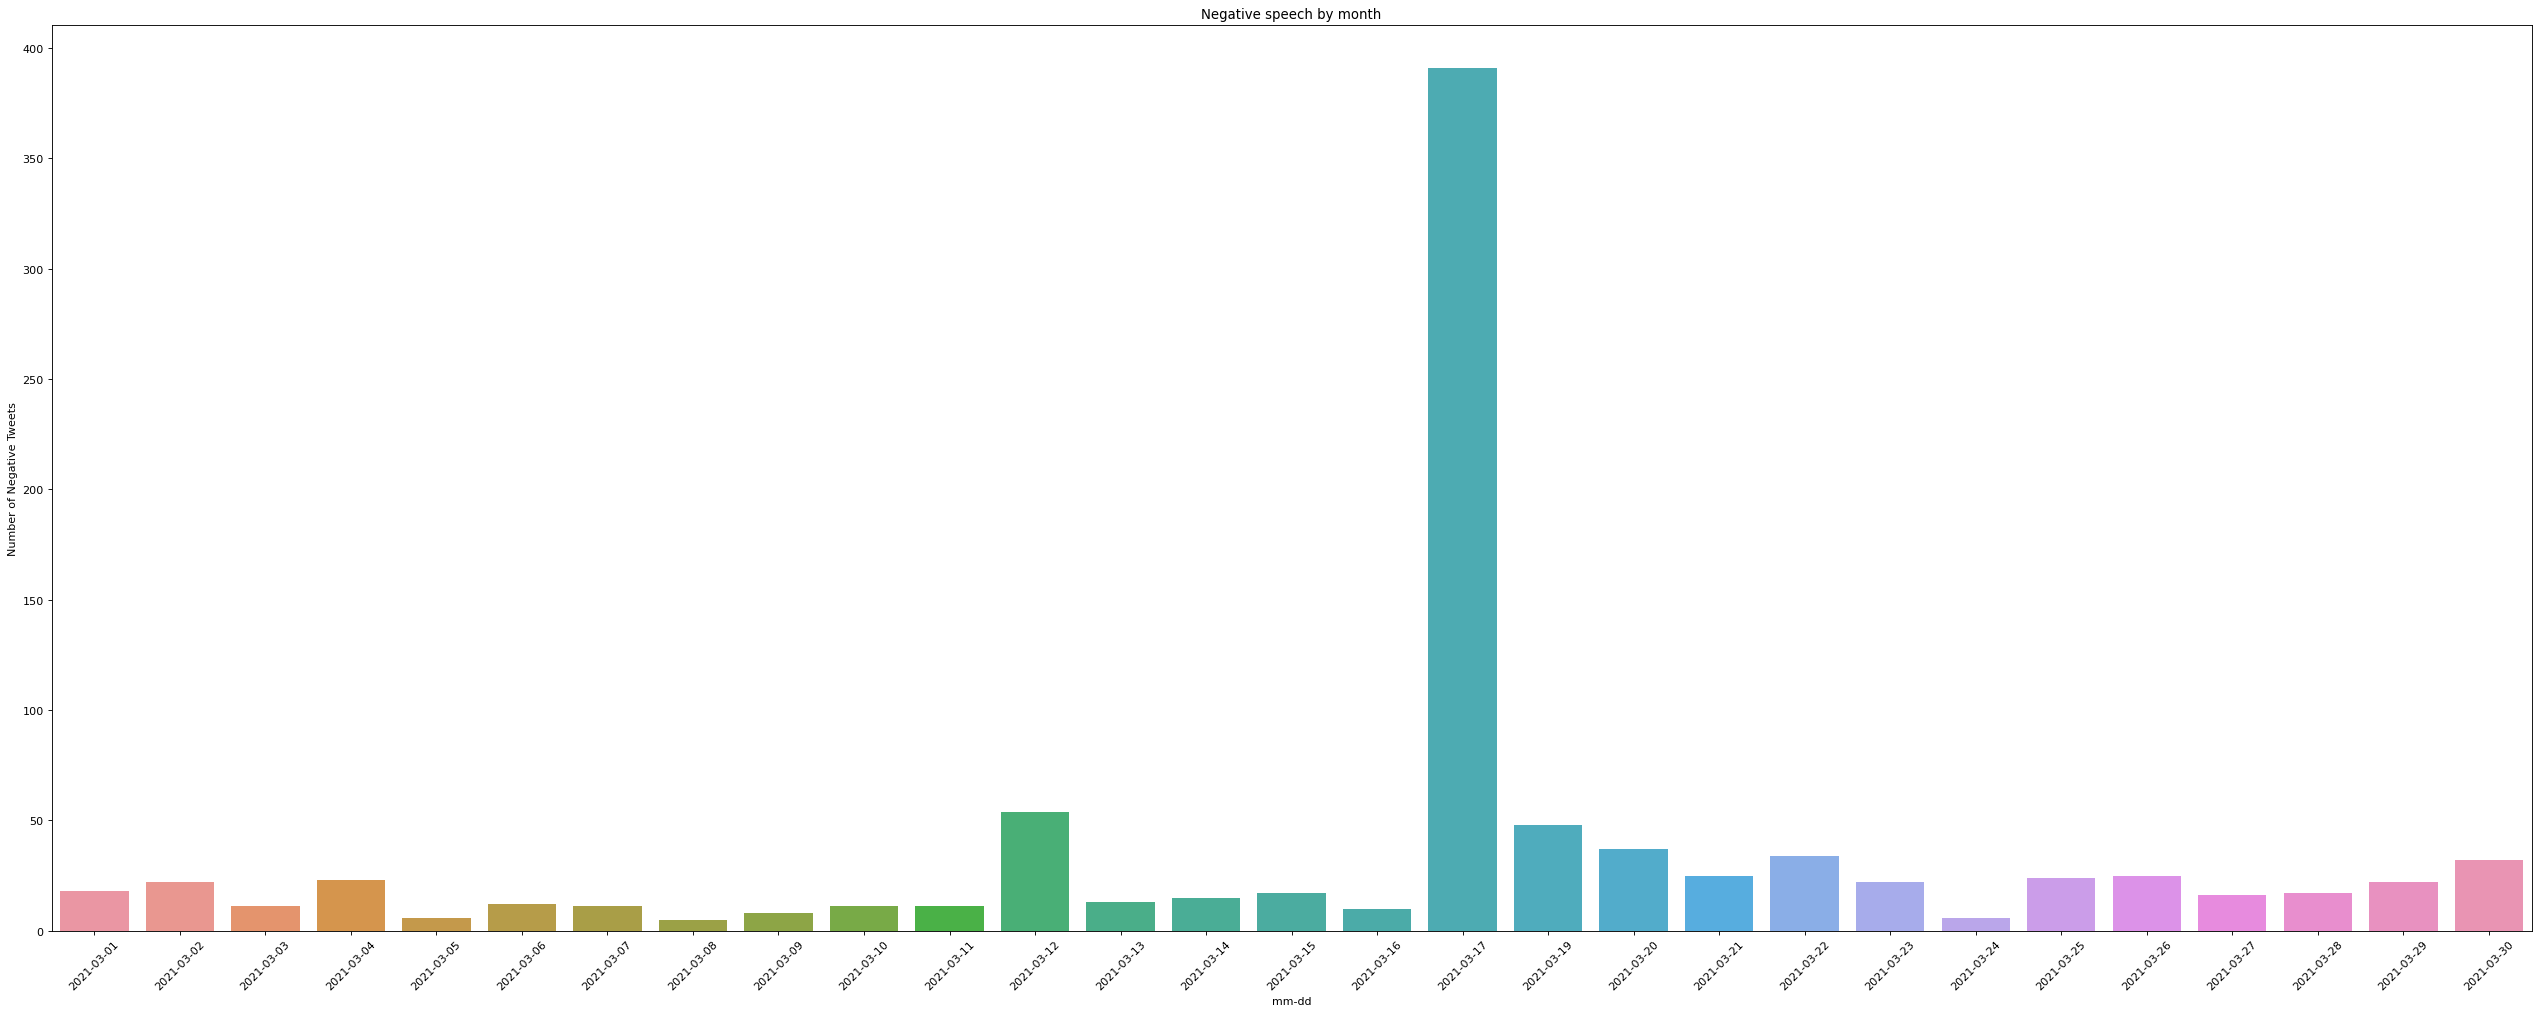

In [ ]:
# Plot the count of nagetive-sentiment speech by date
%matplotlib inline
negative_df2['Date'] = negative_df2['Datetime'].map(lambda datetime: datetime.date())
negative_df2 = negative_df2.sort_values(by='Date')

## Plot
figure(figsize=(40, 15), dpi=80)

ax = sns.countplot(x = 'Date', data = negative_df2)
ax.set(xlabel = 'mm-dd', ylabel = 'Number of Negative Tweets')
plt.xticks(rotation=45)
plt.title('Negative speech by month')
plt.show()

### WordCloud 03/01/2021 - 03/31/2021 Entire time period

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


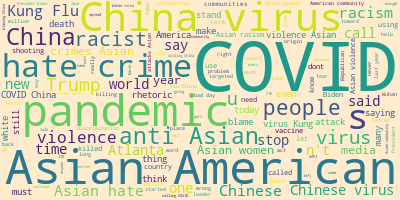

In [ ]:
# Uncomment and install the package if do not have it yet
# pip install wordcloud
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_text = ','.join(list(negative_df2['processedText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="blanchedalmond", max_words=5000, contour_width=3, contour_color='firebrick')
# Generate a word cloud
wordcloud.generate(long_text)
# Visualize the word cloud
wordcloud.to_image()

### WordCloud 03/01/2021 - 03/15/2021 Before Atlanta Shooting

In [ ]:
# Select the negative-setiment reviews within the time range
negative_df2_1 = negative_df2[(negative_df2['Datetime'] >= pd.Timestamp(2021,3,1).tz_localize('US/Eastern')) & (negative_df2['Datetime'] <= pd.Timestamp(2021,3,15).tz_localize('US/Eastern'))]

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


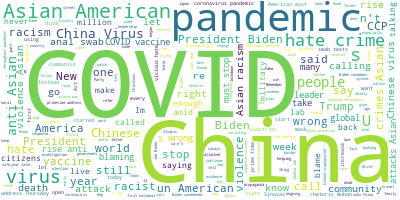

In [ ]:
# Join the different processed titles together.
long_text = ','.join(list(negative_df2_1['processedText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='firebrick')
# Generate a word cloud
wordcloud.generate(long_text)
# Visualize the word cloud
wordcloud.to_image()

### Wordcloud 03/16/2021 - 03/17/2021 (Peak of Event)

In [ ]:
# Select the negative-setiment reviews within the time range
negative_df2_2 = negative_df2[(negative_df2['Datetime'] >= pd.Timestamp(2021,3,16).tz_localize('US/Eastern')) & (negative_df2['Datetime'] <= pd.Timestamp(2021,3,17).tz_localize('US/Eastern'))]

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


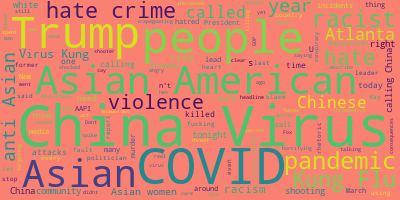

In [ ]:
# Join the different processed titles together.
long_text = ','.join(list(negative_df2_2['processedText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="salmon", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_text)
# Visualize the word cloud
wordcloud.to_image()

### Wordcloud 03/18/2021 - 03/31/2021 (After Event)

In [ ]:
# Select the negative-setiment reviews within the time range
negative_df2_3 = negative_df2[(negative_df2['Datetime'] >= pd.Timestamp(2021,3,18).tz_localize('US/Eastern')) & (negative_df2['Datetime'] <= pd.Timestamp(2021,3,31).tz_localize('US/Eastern'))]

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


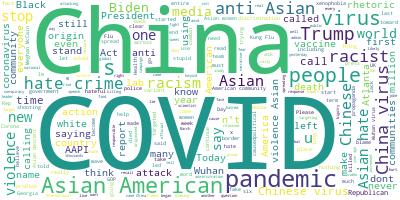

In [ ]:
# Join the different processed titles together.
long_text = ','.join(list(negative_df2_3['processedText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_text)
# Visualize the word cloud
wordcloud.to_image()

### Topic Model 03/01/2021 - 03/15/2021 Before Atlanta Shooting on 03-16-2021

Negative tweets

In [ ]:
data = negative_df2_1['processedText'].values.tolist()
viz1 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.032*"china" + 0.028*"covid" + 0.012*"vaccine" + 0.012*"virus" + '
  '0.012*"say" + 0.009*"look" + 0.008*"talk" + 0.007*"make" + 0.007*"change" + '
  '0.006*"nation"'),
 (1,
  '0.035*"china" + 0.023*"virus" + 0.012*"covid" + 0.011*"call" + '
  '0.011*"chinese" + 0.010*"enough" + 0.010*"racist" + 0.009*"pandemic" + '
  '0.008*"keep" + 0.007*"people"'),
 (2,
  '0.053*"asian" + 0.034*"american" + 0.031*"hate" + 0.029*"pandemic" + '
  '0.025*"crime" + 0.019*"violence" + 0.014*"anti" + 0.013*"biden" + '
  '0.011*"president" + 0.010*"covid"')]


Model Perplexity:  -7.050263369582045


In [ ]:
pyLDAvis.display(viz1)

All tweets

In [ ]:
tweets_df2_1 = tweets_df2[(tweets_df2['Datetime'] >= pd.Timestamp(2021,3,1).tz_localize('US/Eastern')) & (tweets_df2['Datetime'] <= pd.Timestamp(2021,3,15).tz_localize('US/Eastern'))]
data = tweets_df2_1['processedText'].values.tolist()
viz2 = topic_modeling(data, 4)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.049*"china" + 0.028*"virus" + 0.024*"covid" + 0.015*"say" + 0.014*"come" '
  '+ 0.013*"think" + 0.012*"vaccine" + 0.011*"american" + 0.011*"control" + '
  '0.011*"success"'),
 (1,
  '0.036*"china" + 0.032*"covid" + 0.011*"make" + 0.010*"chinese" + '
  '0.008*"vaccine" + 0.007*"test" + 0.007*"time" + 0.006*"give" + '
  '0.005*"citizen" + 0.005*"also"'),
 (2,
  '0.022*"pandemic" + 0.020*"chinese" + 0.019*"america" + 0.014*"explain" + '
  '0.014*"morning" + 0.014*"stricken" + 0.014*"lesson" + 0.014*"reader" + '
  '0.014*"task" + 0.012*"asian"'),
 (3,
  '0.036*"asian" + 0.026*"covid" + 0.025*"china" + 0.022*"racist" + '
  '0.021*"pandemic" + 0.015*"virus" + 0.014*"american" + 0.012*"people" + '
  '0.011*"hate_crime" + 0.011*"chinese"')]


Model Perplexity:  -7.5367349402285715


In [ ]:
pyLDAvis.display(viz2)

### Topic Model 03/16/2021 - 03/17/2021 (Peak of Event)

Negative tweets

In [ ]:
data = negative_df2_2['processedText'].values.tolist()
viz3 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.030*"asian" + 0.025*"virus" + 0.022*"china" + 0.020*"hate" + '
  '0.016*"crime" + 0.014*"covid" + 0.014*"people" + 0.013*"racist" + '
  '0.013*"anti" + 0.011*"violence"'),
 (1,
  '0.035*"asian" + 0.032*"china" + 0.029*"virus" + 0.019*"kung" + '
  '0.018*"covid" + 0.018*"flu" + 0.017*"call" + 0.017*"american" + '
  '0.016*"people" + 0.013*"hate"'),
 (2,
  '0.027*"asian" + 0.019*"hate" + 0.018*"trump" + 0.016*"virus" + '
  '0.015*"pandemic" + 0.014*"china" + 0.014*"call" + 0.014*"attack" + '
  '0.012*"crime" + 0.010*"anti"')]


Model Perplexity:  -6.194987216477642


In [ ]:
pyLDAvis.display(viz3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


All tweets

In [ ]:
tweets_df2_2 = tweets_df2[(tweets_df2['Datetime'] >= pd.Timestamp(2021,3,16).tz_localize('US/Eastern')) & (tweets_df2['Datetime'] <= pd.Timestamp(2021,3,17).tz_localize('US/Eastern'))]
data = tweets_df2_2['processedText'].values.tolist()
viz4 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.013*"china" + 0.013*"virus" + 0.011*"hate" + 0.011*"asian" + '
  '0.010*"crime" + 0.007*"trump" + 0.007*"people" + 0.007*"covid" + '
  '0.005*"american" + 0.005*"community"'),
 (1,
  '0.040*"friend" + 0.040*"aapi" + 0.040*"call" + 0.040*"atlanta" + '
  '0.040*"love" + 0.040*"virus" + 0.040*"china" + 0.039*"language" + '
  '0.039*"send" + 0.039*"complicit"'),
 (2,
  '0.030*"asian" + 0.026*"china" + 0.022*"virus" + 0.017*"covid" + '
  '0.012*"hate" + 0.012*"american" + 0.012*"call" + 0.011*"people" + '
  '0.010*"pandemic" + 0.010*"trump"')]


Model Perplexity:  -6.750623819756741


In [ ]:
pyLDAvis.display(viz4)

### Topic Model 03/18/2021 - 03/31/2021 (After Event)

Negative tweets

In [ ]:
data = negative_df2_3['processedText'].values.tolist()
viz5 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.019*"time" + 0.018*"big" + 0.015*"virus" + 0.015*"covid" + 0.013*"china" '
  '+ 0.011*"chinese" + 0.010*"really" + 0.010*"blame" + 0.010*"people" + '
  '0.009*"star"'),
 (1,
  '0.035*"china" + 0.015*"origin" + 0.015*"pandemic" + 0.015*"report" + '
  '0.014*"covid" + 0.011*"intl" + 0.010*"virus" + 0.009*"chinese" + '
  '0.008*"make" + 0.007*"name"'),
 (2,
  '0.078*"asian" + 0.025*"people" + 0.022*"covid" + 0.022*"hate" + '
  '0.020*"american" + 0.019*"crime" + 0.017*"virus" + 0.017*"racist" + '
  '0.015*"pandemic" + 0.010*"community"')]


Model Perplexity:  -7.243792001736513


In [ ]:
pyLDAvis.display(viz5)

All tweets

In [ ]:
tweets_df2_3 = tweets_df2[(tweets_df2['Datetime'] >= pd.Timestamp(2021,3,18).tz_localize('US/Eastern')) & (tweets_df2['Datetime'] <= pd.Timestamp(2021,3,31).tz_localize('US/Eastern'))]
data = tweets_df2_3['processedText'].values.tolist()
viz6 = topic_modeling(data, 4)

In [ ]:
pyLDAvis.display(viz6)

### Topic Model 03/01/2021 - 03/31/2021 Entire time period

Negative Tweets

In [ ]:
data = negative_df2['processedText'].values.tolist()
viz7 = topic_modeling(data, 3)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.051*"china" + 0.040*"virus" + 0.025*"covid" + 0.016*"chinese" + '
  '0.014*"call" + 0.013*"trump" + 0.010*"say" + 0.010*"people" + 0.007*"make" '
  '+ 0.007*"get"'),
 (1,
  '0.015*"biden" + 0.012*"pandemic" + 0.009*"president" + 0.009*"first" + '
  '0.009*"address" + 0.008*"continue" + 0.007*"follow" + 0.006*"become" + '
  '0.006*"work" + 0.006*"hard"'),
 (2,
  '0.078*"asian" + 0.030*"american" + 0.029*"hate" + 0.025*"pandemic" + '
  '0.020*"anti" + 0.019*"covid" + 0.019*"violence" + 0.017*"crime" + '
  '0.011*"community" + 0.010*"people"')]


Model Perplexity:  -7.182572017882946


In [ ]:
pyLDAvis.display(viz7)

All tweets

In [ ]:
data = tweets_df2['processedText'].values.tolist()
viz8 = topic_modeling(data, 5)

F:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.039*"china" + 0.020*"covid" + 0.014*"wuhan" + 0.014*"virus" + 0.012*"let" '
  '+ 0.011*"joke" + 0.010*"origin" + 0.010*"go" + 0.010*"lab" + '
  '0.009*"variant"'),
 (1,
  '0.073*"asian" + 0.043*"virus" + 0.029*"pandemic" + 0.028*"china" + '
  '0.026*"hate" + 0.026*"american" + 0.020*"people" + 0.019*"anti" + '
  '0.017*"covid" + 0.017*"say"'),
 (2,
  '0.023*"know" + 0.013*"america" + 0.012*"pandemic" + 0.010*"murder" + '
  '0.009*"black" + 0.009*"chinese" + 0.009*"good" + 0.009*"world" + '
  '0.009*"matter" + 0.008*"fear"'),
 (3,
  '0.048*"covid" + 0.026*"china" + 0.018*"make" + 0.013*"get" + '
  '0.012*"vaccine" + 0.012*"chinese" + 0.012*"see" + 0.011*"go" + 0.009*"take" '
  '+ 0.009*"biden"'),
 (4,
  '0.019*"talk" + 0.014*"family" + 0.012*"vaccine" + 0.011*"man" + '
  '0.008*"send" + 0.008*"already" + 0.008*"solidarity" + 0.007*"dead" + '
  '0.007*"wave" + 0.006*"platform"')]


Model Perplexity:  -7.533080847172451


In [ ]:
pyLDAvis.display(viz8)